In [1]:
import pandas as pd
from feature_creation import data_copy
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, Normalizer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from os import cpu_count
import numpy as np
import seaborn as sns

In [2]:
data_copy['increase_stock'] = data_copy['increase_stock'].apply(lambda entity: 1 if entity == 'high_bike_demand' else 0)
data_copy['increase_stock'] = data_copy['increase_stock'].astype('int')
data_copy = data_copy.drop('holiday',axis=1)
data_copy = data_copy.drop('snowdepth',axis=1)
data_copy = data_copy.drop('visibility',axis=1)
data_copy = data_copy.drop('weather_score_daytime',axis=1)
data_copy.describe()

,weekday,summertime,temp,dew,humidity,precip,windspeed,cloudcover,increase_stock,daytime,rushhour,weather_score
count,1600.000000,1600.00000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,0.710000,0.64375,15.210313,7.750750,63.927844,0.122042,13.082500,64.322375,0.180000,0.543750,0.205625,0.180000
std,0.453904,0.47904,9.264785,10.026459,19.079419,0.920600,7.756652,32.748869,0.384308,0.498238,0.404284,0.184322
min,0.000000,0.00000,-9.100000,-18.400000,15.850000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.239787
25%,0.000000,0.00000,7.700000,-0.800000,47.845000,0.000000,7.500000,28.800000,0.000000,0.000000,0.000000,0.049945
50%,1.000000,1.00000,15.500000,8.300000,65.175000,0.000000,12.300000,79.300000,0.000000,1.000000,0.000000,0.154343
75%,1.000000,1.00000,23.200000,16.800000,79.955000,0.000000,17.600000,92.800000,0.000000,1.000000,0.000000,0.278779
max,1.000000,1.00000,35.600000,24.300000,99.890000,25.871000,43.800000,100.000000,1.000000,1.000000,1.000000,0.956538


In [3]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   hour_of_day     1600 non-null   category
 1   day_of_week     1600 non-null   category
 2   month           1600 non-null   category
 3   weekday         1600 non-null   int64   
 4   summertime      1600 non-null   int64   
 5   temp            1600 non-null   float64 
 6   dew             1600 non-null   float64 
 7   humidity        1600 non-null   float64 
 8   precip          1600 non-null   float64 
 9   windspeed       1600 non-null   float64 
 10  cloudcover      1600 non-null   float64 
 11  increase_stock  1600 non-null   int64   
 12  daytime         1600 non-null   int64   
 13  rushhour        1600 non-null   int64   
 14  weather_score   1600 non-null   float64 
dtypes: category(3), float64(7), int64(5)
memory usage: 156.3 KB


In [4]:
X = data_copy.drop('increase_stock',axis=1)
Y = data_copy['increase_stock']

## Make preprocessor pipeline 

In [5]:
float_labels = list(X.select_dtypes(include='float').columns)
category_labels = list(X.select_dtypes(include='category').columns)

In [6]:
def all_poly_pipeline(c_value):
    pre = ColumnTransformer([
        ('num', StandardScaler(), float_labels),
        ('cat', OneHotEncoder(), category_labels)
    ],
        remainder='passthrough')
    return Pipeline([
        ('pre',pre),
        ('poly',PolynomialFeatures(include_bias=False)),
        ('model',LogisticRegression(penalty='l1', C=c_value,solver='liblinear', max_iter=10000))
    ])
def numeric_poly_pipeline(c_value):
    pre_numeric = Pipeline([
        ('stand',StandardScaler()),
        ('poly',PolynomialFeatures(include_bias=False))
    ])
    pre = ColumnTransformer([
        ('num', pre_numeric, float_labels),
        ('cat', OneHotEncoder(), category_labels)
    ])
    return Pipeline([
        ('pre',pre),
        ('model',LogisticRegression(penalty='l1', C=c_value,solver='liblinear', max_iter=10000))
    ])

In [7]:
def do_classification_report(model,x_data=X,Y_data=Y, cross_validations=160):
    y_hats = cross_val_predict(model, x_data, Y_data, cv=cross_validations, n_jobs=cpu_count())
    print(classification_report(Y,y_hats))

In [8]:
kf = KFold(n_splits=10, shuffle=True, random_state=123)

In [9]:
def show_model_ceofs(trained_model):
    trained_model_names = trained_model[:-1].get_feature_names_out()
    trained_model_coefs = trained_model.named_steps['model'].coef_[0]
    print(f'len coefs: {len(trained_model_coefs)}, labels: {len(trained_model_names)}, non-zero terms: {len(np.nonzero(trained_model_coefs)[0])}')
    for item in zip(trained_model_names, trained_model_coefs):
        if abs(item[1]) > 0:
            print(f'{item[0]} = {item[1]}')

### optimize on trained split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=123)

In [11]:
def optimize_lambda(xt, yt, pipline):
    mean_cross_val_scores = []
    for i in range(1,200, 2):
        result = {}
        c = i/100
        model_pipeline = pipline(c)
        
        cvs = cross_val_score(model_pipeline, xt, yt, cv=kf, scoring='accuracy', n_jobs=cpu_count())
        result['cvs'] = cvs
        result['mean_perf'] = np.mean(cvs)
        result['reg_val'] = c
        mean_cross_val_scores.append(result)
    return pd.DataFrame(mean_cross_val_scores)    

### optimize training for all poly variables

cvs          [0.9166666666666666, 0.9236111111111112, 0.888...
mean_perf                                             0.905556
reg_val                                                   0.19
Name: 9, dtype: object


<Axes: xlabel='reg_val', ylabel='mean_perf'>

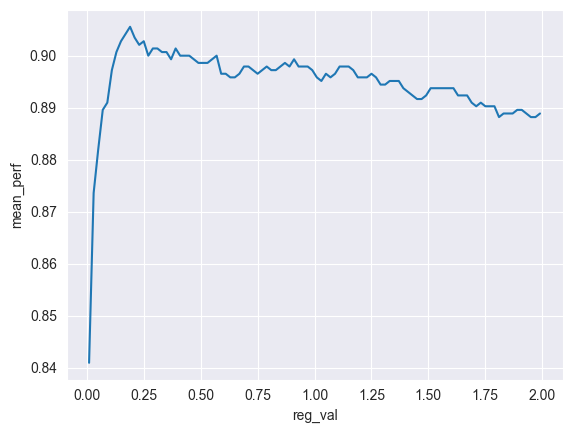

In [12]:
performance_df = optimize_lambda(X_train, y_train,pipline=all_poly_pipeline)
first_max = performance_df.loc[performance_df['mean_perf'].idxmax()]
print(first_max)
sns.lineplot(y=performance_df['mean_perf'],x=performance_df['reg_val'])

In [13]:
#out of sample test with optimal c
all_poly_model = all_poly_pipeline(first_max['reg_val'])
all_poly_model.fit(X_train, y_train)
show_model_ceofs(all_poly_model)

len coefs: 1539, labels: 1539, non-zero terms: 50
num__temp = 0.04761871140639107
num__cloudcover = -0.016684351329011964
num__weather_score = 0.9965674808406542
cat__hour_of_day_7 = -0.08806627750635287
cat__month_5 = -0.2826296484662362
remainder__weekday = -0.373145650255767
remainder__daytime = 0.8284869929034945
remainder__rushhour = 0.12362762904671724
num__temp^2 = -0.20166854229668107
num__temp num__dew = -0.32223461724868374
num__temp cat__hour_of_day_12 = 0.006494501297464695
num__temp cat__hour_of_day_17 = 0.1492773987918249
num__temp remainder__rushhour = 0.01368228973764698
num__dew^2 = -0.3067322317672948
num__dew num__cloudcover = 0.10579803503347827
num__humidity^2 = -0.38223933986503156
num__humidity cat__day_of_week_1 = 0.063660720970492
num__humidity remainder__weekday = 0.19426798105531717
num__precip^2 = -0.1845035782188537
num__windspeed^2 = -0.10082504183944617
num__windspeed cat__day_of_week_1 = -0.14135983461970272
num__windspeed cat__month_5 = -0.2835717485574

In [14]:
#test data report using hold out
y_hat = all_poly_model.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       131
           1       0.67      0.55      0.60        29

    accuracy                           0.87       160
   macro avg       0.79      0.75      0.76       160
weighted avg       0.86      0.87      0.86       160


In [15]:
#report using training on all data
do_classification_report(all_poly_pipeline(.19))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1312
           1       0.78      0.66      0.71       288

    accuracy                           0.91      1600
   macro avg       0.85      0.81      0.83      1600
weighted avg       0.90      0.91      0.90      1600


### now look at only numeric poly vars

cvs          [0.8888888888888888, 0.9236111111111112, 0.861...
mean_perf                                                  0.9
reg_val                                                   1.15
Name: 57, dtype: object


<Axes: xlabel='reg_val', ylabel='mean_perf'>

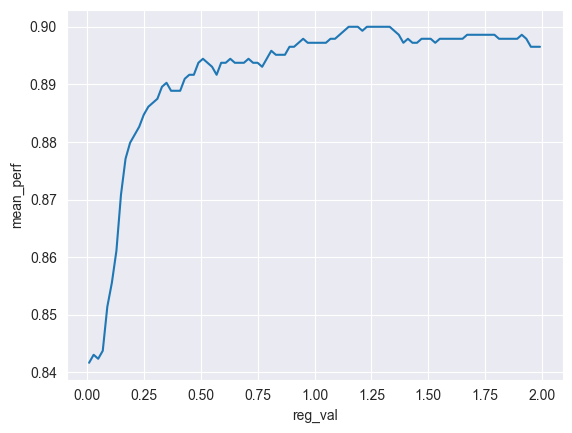

In [16]:
performance_df = optimize_lambda(X_train, y_train, pipline=numeric_poly_pipeline)
first_max = performance_df.loc[performance_df['mean_perf'].idxmax()]
print(first_max)
sns.lineplot(y=performance_df['mean_perf'],x=performance_df['reg_val'])

In [17]:
num_poly_model = numeric_poly_pipeline(first_max['reg_val'])
num_poly_model.fit(X_train,y_train)
show_model_ceofs(num_poly_model)

len coefs: 78, labels: 78, non-zero terms: 51
num__temp = 0.5804953131211603
num__precip = -0.3878539002276047
num__cloudcover = -0.02181234248367886
num__weather_score = 1.2382836694789403
num__temp dew = -0.7939774729575867
num__temp windspeed = -0.03765203884136564
num__dew humidity = -0.17288423714125273
num__dew cloudcover = 0.26810073926553146
num__dew weather_score = -0.1646153458856595
num__humidity^2 = -0.3939084829062752
num__humidity precip = -1.5414519107508133
num__windspeed^2 = -0.0776705675874535
num__windspeed cloudcover = 0.05395753823009713
num__windspeed weather_score = -0.038145379886269905
num__cloudcover^2 = -0.0633976344886213
cat__hour_of_day_0 = -2.501732478806138
cat__hour_of_day_1 = -2.323657330931668
cat__hour_of_day_2 = -1.376016556085348
cat__hour_of_day_3 = -1.9731529923840356
cat__hour_of_day_4 = -2.207597787066989
cat__hour_of_day_5 = -1.8741050754981219
cat__hour_of_day_6 = -1.5469418920477067
cat__hour_of_day_7 = -0.7109681558901859
cat__hour_of_day_8

In [18]:
#run holdout data on new model
y_hat = num_poly_model.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       131
           1       0.66      0.66      0.66        29

    accuracy                           0.88       160
   macro avg       0.79      0.79      0.79       160
weighted avg       0.88      0.88      0.88       160


In [19]:
do_classification_report(num_poly_model)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1312
           1       0.74      0.65      0.69       288

    accuracy                           0.90      1600
   macro avg       0.83      0.80      0.81      1600
weighted avg       0.89      0.90      0.89      1600


# Show Correlation matrix of latest features
## start with numerical poly

In [20]:
numerical_interaction_data = pd.DataFrame(
    num_poly_model[0].transform(X),
    columns=list(num_poly_model[:-1].get_feature_names_out())
)
numerical_interaction_data['is_high_demand'] = Y

In [21]:
numerical_interaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 79 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   num__temp                      1600 non-null   float64
 1   num__dew                       1600 non-null   float64
 2   num__humidity                  1600 non-null   float64
 3   num__precip                    1600 non-null   float64
 4   num__windspeed                 1600 non-null   float64
 5   num__cloudcover                1600 non-null   float64
 6   num__weather_score             1600 non-null   float64
 7   num__temp^2                    1600 non-null   float64
 8   num__temp dew                  1600 non-null   float64
 9   num__temp humidity             1600 non-null   float64
 10  num__temp precip               1600 non-null   float64
 11  num__temp windspeed            1600 non-null   float64
 12  num__temp cloudcover           1600 non-null   f

In [22]:
import matplotlib.pyplot as plt
corr_matrix_num = numerical_interaction_data.corr()
corr_with_demand = corr_matrix_num['is_high_demand'].sort_values(ascending=False)
corr_with_demand = corr_with_demand[1:-1]
corr_with_demand = corr_with_demand[abs(corr_with_demand) > .1]
print(f'{len(corr_with_demand)} features above threshold')
for item in corr_with_demand.index:
    print(f'{item} = {corr_with_demand[item]}')

23 features above threshold
num__weather_score = 0.47962106792142584
num__temp = 0.33698134745043257
num__weather_score^2 = 0.3078763324692289
cat__hour_of_day_18 = 0.26779747147241256
cat__hour_of_day_17 = 0.23573758181889196
num__temp weather_score = 0.1804190183962588
cat__hour_of_day_15 = 0.17832223693490257
cat__hour_of_day_16 = 0.17649020504964477
num__dew = 0.13266340715327105
cat__hour_of_day_19 = 0.12937010001890242
cat__day_of_week_5 = 0.1155781317595778
num__humidity^2 = 0.10749757113241655
num__temp dew = -0.1003222315616879
cat__hour_of_day_21 = -0.10096125908620182
cat__hour_of_day_23 = -0.1053476221221722
num__cloudcover weather_score = -0.1059685855280413
num__dew humidity = -0.10678552497628431
cat__month_12 = -0.10780000862400108
cat__month_1 = -0.10817688326842985
num__dew^2 = -0.11017621534532282
cat__hour_of_day_0 = -0.11028574181845031
num__temp humidity = -0.2461566033217089
num__humidity weather_score = -0.30088916509536423


/var/folders/wg/5g_37w5920gg12w48ly3r9qh0000gn/T/ipykernel_30058/1282308239.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_demand.index, y=corr_with_demand.values, palette='viridis')


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [Text(0, 0, 'num__weather_score'),
  Text(1, 0, 'num__temp'),
  Text(2, 0, 'num__weather_score^2'),
  Text(3, 0, 'cat__hour_of_day_18'),
  Text(4, 0, 'cat__hour_of_day_17'),
  Text(5, 0, 'num__temp weather_score'),
  Text(6, 0, 'cat__hour_of_day_15'),
  Text(7, 0, 'cat__hour_of_day_16'),
  Text(8, 0, 'num__dew'),
  Text(9, 0, 'cat__hour_of_day_19'),
  Text(10, 0, 'cat__day_of_week_5'),
  Text(11, 0, 'num__humidity^2'),
  Text(12, 0, 'num__temp dew'),
  Text(13, 0, 'cat__hour_of_day_21'),
  Text(14, 0, 'cat__hour_of_day_23'),
  Text(15, 0, 'num__cloudcover weather_score'),
  Text(16, 0, 'num__dew humidity'),
  Text(17, 0, 'cat__month_12'),
  Text(18, 0, 'cat__month_1'),
  Text(19, 0, 'num__dew^2'),
  Text(20, 0, 'cat__hour_of_day_0'),
  Text(21, 0, 'num__temp humidity'),
  Text(22, 0, 'num__humidity weather_score')])

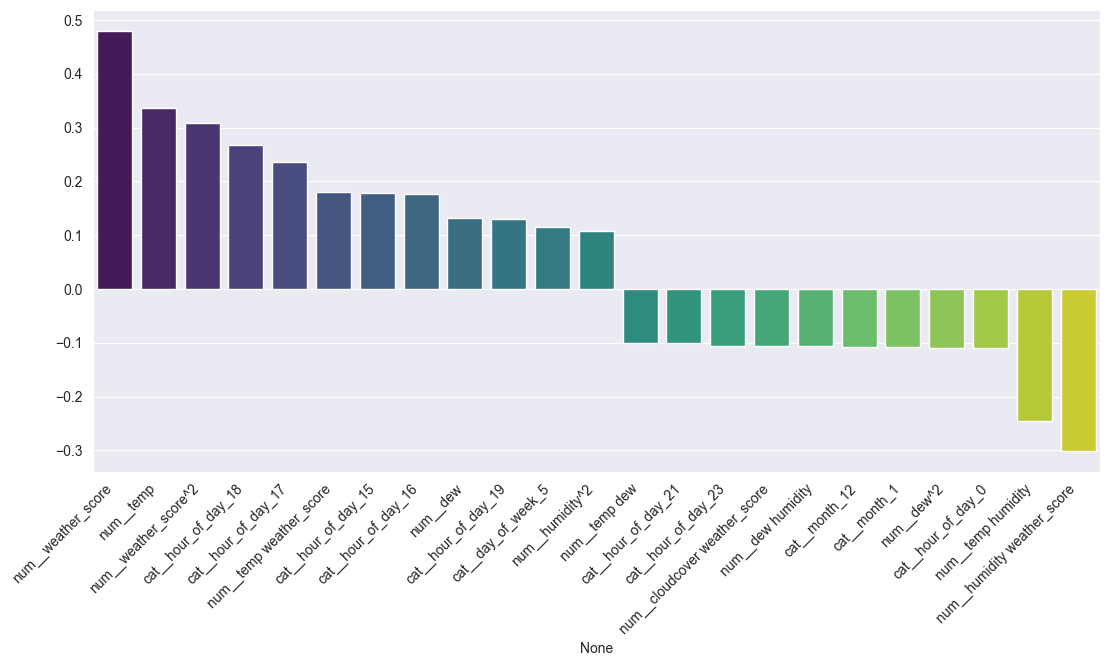

In [23]:
# Create a bar plot
plt.figure(figsize=(13, 6))
sns.barplot(x=corr_with_demand.index, y=corr_with_demand.values, palette='viridis')
plt.xticks(rotation=45, ha='right')

### now look at all poly combos

In [24]:
all_interaction_data = pd.DataFrame(
    all_poly_model[1].transform(all_poly_model[0].transform(X).toarray()),
    columns=list(all_poly_model[:-1].get_feature_names_out())
)
all_interaction_data['is_high_demand'] = Y

In [25]:
corr_matrix_all = all_interaction_data.corr()
corr_all_with_demand = corr_matrix_all['is_high_demand'].sort_values(ascending=False)
corr_all_with_demand = corr_all_with_demand[1:-1]
corr_all_with_demand = corr_all_with_demand[abs(corr_all_with_demand) > .3]
print(f'{len(corr_all_with_demand)} features above threshold')
for item in corr_all_with_demand.index:
    print(f'{item} = {corr_all_with_demand[item]}')

22 features above threshold
remainder__summertime remainder__rushhour = 0.5149685698884214
remainder__summertime remainder__daytime = 0.4916888121171702
remainder__rushhour^2 = 0.4821369383923177
remainder__daytime remainder__rushhour = 0.4821369383923177
remainder__rushhour = 0.4821369383923177
num__weather_score = 0.47962106792142584
num__weather_score remainder__daytime = 0.47925096345957746
num__weather_score remainder__rushhour = 0.47238311197351174
num__weather_score remainder__summertime = 0.4585017161945473
remainder__daytime = 0.4128410166236785
remainder__daytime^2 = 0.4128410166236785
num__temp remainder__rushhour = 0.4096830735949335
num__temp remainder__daytime = 0.3907193698751753
remainder__weekday remainder__rushhour = 0.36760295173194957
num__weather_score remainder__weekday = 0.34367098934813056
num__temp = 0.33698134745043257
num__weather_score^2 = 0.3078763324692289
num__humidity num__weather_score = -0.30088916509536423
num__humidity = -0.3087264954222272
num__humi

/var/folders/wg/5g_37w5920gg12w48ly3r9qh0000gn/T/ipykernel_30058/1343630739.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_all_with_demand.index, y=corr_all_with_demand.values, palette='viridis')


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21],
 [Text(0, 0, 'remainder__summertime remainder__rushhour'),
  Text(1, 0, 'remainder__summertime remainder__daytime'),
  Text(2, 0, 'remainder__rushhour^2'),
  Text(3, 0, 'remainder__daytime remainder__rushhour'),
  Text(4, 0, 'remainder__rushhour'),
  Text(5, 0, 'num__weather_score'),
  Text(6, 0, 'num__weather_score remainder__daytime'),
  Text(7, 0, 'num__weather_score remainder__rushhour'),
  Text(8, 0, 'num__weather_score remainder__summertime'),
  Text(9, 0, 'remainder__daytime'),
  Text(10, 0, 'remainder__daytime^2'),
  Text(11, 0, 'num__temp remainder__rushhour'),
  Text(12, 0, 'num__temp remainder__daytime'),
  Text(13, 0, 'remainder__weekday remainder__rushhour'),
  Text(14, 0, 'num__weather_score remainder__weekday'),
  Text(15, 0, 'num__temp'),
  Text(16, 0, 'num__weather_score^2'),
  Text(17, 0, 'num__humidity num__weather_score'),
  Text(18, 0, 'num__hu

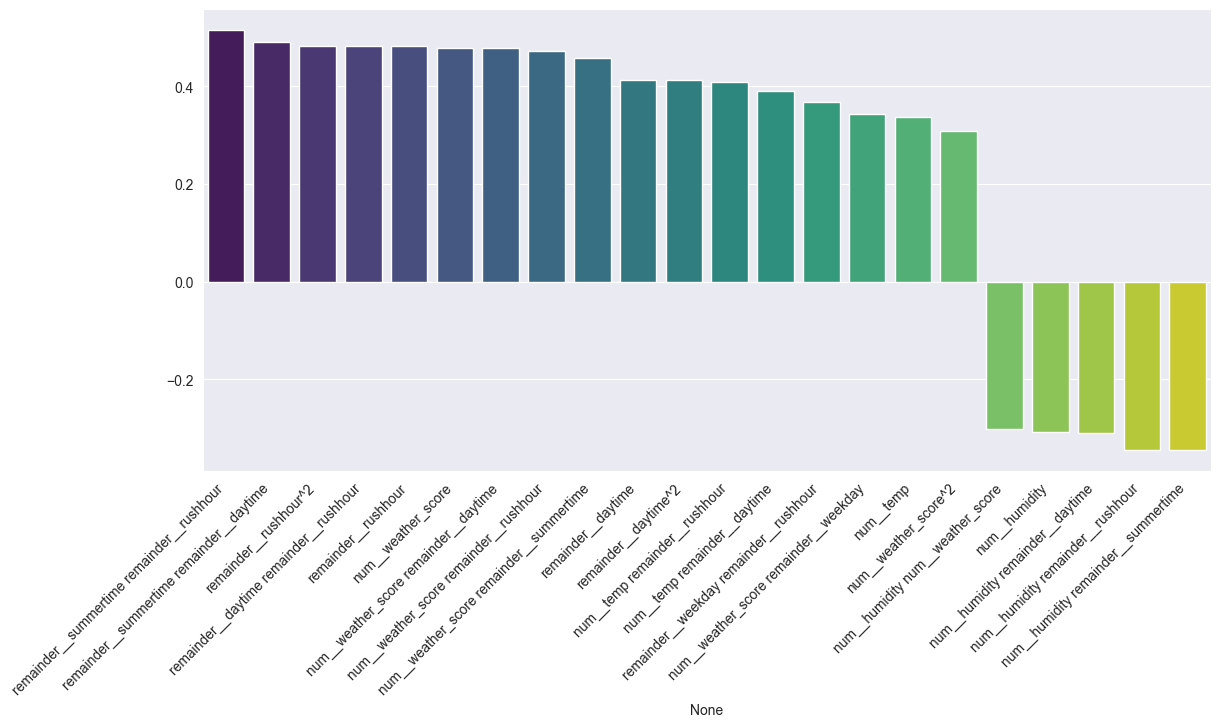

In [26]:

# Create a bar plot
plt.figure(figsize=(13, 6))
sns.barplot(x=corr_all_with_demand.index, y=corr_all_with_demand.values, palette='viridis')
plt.xticks(rotation=45, ha='right')

In [27]:
# all_interaction_data.to_csv(path_or_buf='../data/all_interactions.csv')

In [28]:
# numerical_interaction_data.to_csv(path_or_buf='../data/numerical_interactions.csv')